# Redshift and Template Fitting

This notebook covers basic examples on how a user can measure the redshift of a source using the visualization tool [Jdaviz](https://jdaviz.readthedocs.io/en/latest/) or programmatically with [Specutils](https://specutils.readthedocs.io/en/latest/).

**Use case:** measure the redshift of a galaxy from its spectrum using 2 different methods.  
**Data:** JWST/NIRSpec spectrum from program 2736.  
**Tools:** jdaviz, specutils.  
**Cross-instrument:** NIRISS, NIRCam.  

**Content**
- [Resources and documentation](#resources)
- [Installation](#installation)
- [Imports](#imports)
- [Fetch the example data](#data)
- ["By eye" redshift measurement with Specviz](#byeye)
- [Redshift measurement with cross-correlation method](#crosscorr)
    - [Get a template and prepare it for use](#get_template)
    - [Subtract the continuum from the observed spectrum](#continuum)
    - [Clean up the spectrum](#cleanup)
    - [Run the cross correlation function](#run_crosscorr)

**Author**: Camilla Pacifici (cpacifici@stsci.edu)<br>
**Updated**: September 14, 2023

<a id='resources'></a>
## Resources and documentation

This notebook uses functionality from [Specutils](https://specutils.readthedocs.io/en/stable/) and [Jdaviz](https://jdaviz.readthedocs.io/en/latest/). Developers at the Space Telescope Science Institute are available to answer questions and resolve problems through the [JWST Help Desk](https://jwsthelp.stsci.edu/). If you wish to send feedback or report problems, you can also submit an issue directly on Github, both for [Specutils](https://github.com/astropy/specutils) and for [Jdaviz](https://github.com/spacetelescope/jdaviz).

<a id='installation'></a>
## Installation

This notebook was extracted from the [JWebbinar material](https://www.stsci.edu/jwst/science-execution/jwebbinars).
To run this notebook, you will need to create an environment that includes the jdaviz package with the following instructions.    
`conda create -n jdaviz python=3.11`  
`conda activate jdaviz`  
from the latest release  
`pip install jdaviz`  
or from git  
`pip install git+https://github.com/spacetelescope/jdaviz.git`

<a id='imports'></a>
## Imports

In [1]:
# general os
import tempfile

# numpy
import numpy as np

# astroquery
from astroquery.mast import Observations

# specviz
import jdaviz # this is needed to get the version number later
from jdaviz import Specviz

# astropy
import astropy # again for the version number
import astropy.units as u
from astropy.io import ascii, fits
from astropy.utils.data import download_file
from astropy.modeling.models import Linear1D
from astropy.nddata import StdDevUncertainty

# specutils
import specutils # again for the version number
from specutils import Spectrum1D, SpectralRegion
from specutils.fitting import fit_generic_continuum
from specutils.analysis import correlation
from specutils.manipulation import extract_region

# glue
from glue.core.roi import XRangeROI

# matplotlib
from matplotlib import pyplot as plt

# display
from IPython.display import display, HTML

In [2]:
# customization of matplotlib style
plt.rcParams["figure.figsize"] = (10, 5)
params = {'legend.fontsize': '18', 'axes.labelsize': '18',
          'axes.titlesize': '18', 'xtick.labelsize': '18',
          'ytick.labelsize': '18', 'lines.linewidth': 2,
          'axes.linewidth': 2, 'animation.html': 'html5',
          'figure.figsize': (8, 6)}
plt.rcParams.update(params)
plt.rcParams.update({'figure.max_open_warning': 0})
# This ensures that our notebook is using the full width of the browser
display(HTML("<style>.container { width:100% !important; }</style>"))

### Versions:

In [3]:
print("jdaviz:", jdaviz.__version__)
print("astropy:", astropy.__version__)
print("specutils:", specutils.__version__)

jdaviz: 3.7.0
astropy: 5.3.4
specutils: 1.12.0


<a id='data'></a>
## Fetch the example data

Here we download a spectrum from the [Early Release Observation data](https://www.stsci.edu/jwst/science-execution/approved-programs/webb-first-image-observations) program 2736 and a model spectrum we will use as template for the redshift measurement. The template is based on a combination of Simple Stellar Population models including emission lines as done in [Pacifici et al. (2012)](https://ui.adsabs.harvard.edu/abs/2012MNRAS.421.2002P/abstract).

In [4]:
# Select a specific directory on your machine or a temporary directory
data_dir = tempfile.gettempdir()
# Get the file from MAST
fn = "jw02736-o007_s09239_nirspec_f170lp-g235m_x1d.fits"
result = Observations.download_file(f"mast:JWST/product/{fn}", local_path=f'{data_dir}/{fn}')

fn_template = download_file('https://stsci.box.com/shared/static/3rkurzwl0l79j70ddemxafhpln7ljle7.dat', cache=True)

Jdaviz will read by default the surface brightness extension (in MJy/sr), but I prefer the flux extension (in Jy). I create a Spectrum1D object reading the file myself.

In [5]:
hdu = fits.open(f'{data_dir}/{fn}')
wave = hdu[1].data['WAVELENGTH'] * u.Unit(hdu[1].header['TUNIT1'])
flux = hdu[1].data['FLUX'] * u.Unit(hdu[1].header['TUNIT2'])
# std = hdu[1].data['FLUX_ERROR'] * u.Unit(hdu[1].header['TUNIT3']) # These are all nan. Define an artificial uncertainty

fluxobs = Spectrum1D(spectral_axis=wave,
                     flux=flux,
                     uncertainty=StdDevUncertainty(0.1*flux))
fluxobs

<Spectrum1D(flux=<Quantity [0., 0., 0., ..., 0., 0., 0.] Jy>, spectral_axis=<SpectralAxis [1.64723761, 1.64830174, 1.64936586, ..., 3.17727368, 3.17832913,
   3.17938458] um>, uncertainty=StdDevUncertainty([0., 0., 0., ..., 0., 0., 0.]))>

<a id='byeye'></a>
## "By eye" redshift measurement with Specviz

Specviz will allow you to match line wavelengths to the emission lines you see in the spectrum. You will be able to do this using the [redshift slider](https://jdaviz.readthedocs.io/en/latest/specviz/plugins.html#redshift-slider) in the Line List plugin. But first, let us [open the spectrum in Specviz](https://jdaviz.readthedocs.io/en/latest/specviz/import_data.html).

In [6]:
# Call the app
viz = Specviz()
viz.show()

Application(config='specviz', docs_link='https://jdaviz.readthedocs.io/en/v3.7.0/specviz/index.html', events=[…

In [7]:
# Load spectrum
# viz.load_data(f'{data_dir}/{fn}', data_label="NIRSpec") # To load the surface brightness directly from file
viz.load_data(fluxobs, data_label='NIRSpec')

Now we need to:
- Open the ["line list" plugin](https://jdaviz.readthedocs.io/en/latest/specviz/plugins.html?highlight=plugin#line-lists)
<img src='./line_list.png' alt="The line list plugin is in the menu to the right" width="500"/>

- Choose pre-loaded lines or add custom lines (the lines will not show in the viewer because they are plotted at restframe)
    - Hint: select Ha and the surrounding NII lines
<img src='./select_list.png' alt="Select the SDSS list" width="500"/>
<img src='./select_three_lines.png' alt="Select the two [NII] lines and the H alpha line" width="500"/>

- Input a guess redshift
<img src='./guess_redshift.png' alt="Input a guess for the redshift (redshift=2.4)" width="500"/>

- Move the slider to get a better match
<img src='./adjust_redshift_slider.png' alt="Adjust the redshift using the slider to match the emission lines in the spectrum" width="500"/>

- Use the [zoom tool](https://jdaviz.readthedocs.io/en/latest/specviz/displaying.html#pan-zoom) to get an even better match
<img src='./precise_adjust_with_zoom.png' alt="Use the zoom tool to find a better match to the emission lines" width="500"/>

<a id='crosscorr'></a>
## Redshift measurement with cross-correlation method

It is very common in astronomy to measure a redshift using a cross-correlation algorithm. IRAF uses this methodology in its [xcsao](http://tdc-www.harvard.edu/iraf/rvsao/xcsao/xcsao.html) task. Here, we use the Specutils [template cross-correlation](https://specutils.readthedocs.io/en/stable/analysis.html#template-cross-correlation) function to derive the redshift of our source. There are a couple of things that we need to do before we run the correlation algorithm:
- Get a template spectrum for the correlation
- Subtract the continuum from both the template and the observed spectrum
- Make sure the spectra have some overlap in wavelength

<a id='get_template'></a>
### Get a template and prepare it for use
The template is used for cross correlation, so it can be renormalized for convenience. The units have to match the units of the observed spectrum. We can do the continuum subtraction in erg/(s cm^2 A) since the continuum is close to linear and then run it by Jdaviz to get the appropriate conversion.

In [8]:
# Define unit
spec_unit = u.erg / u.s / u.cm**2 / u.AA

# Read spectrum with the ascii function
template = ascii.read(fn_template)
# Create Spectrum1D object
template = Spectrum1D(spectral_axis=template['col1']/1E4*u.um, 
                      flux=(template['col2']/1E24)*spec_unit) # Normalize to something close to the observed spectrum

In [9]:
# Cut to useful range - template and obs MUST overlap, so we go to 2.4um.
use_tmp = (template.spectral_axis.value > 0.45) & (template.spectral_axis.value < 2.4)
template_cut = Spectrum1D(spectral_axis=template.spectral_axis[use_tmp], flux=template.flux[use_tmp])

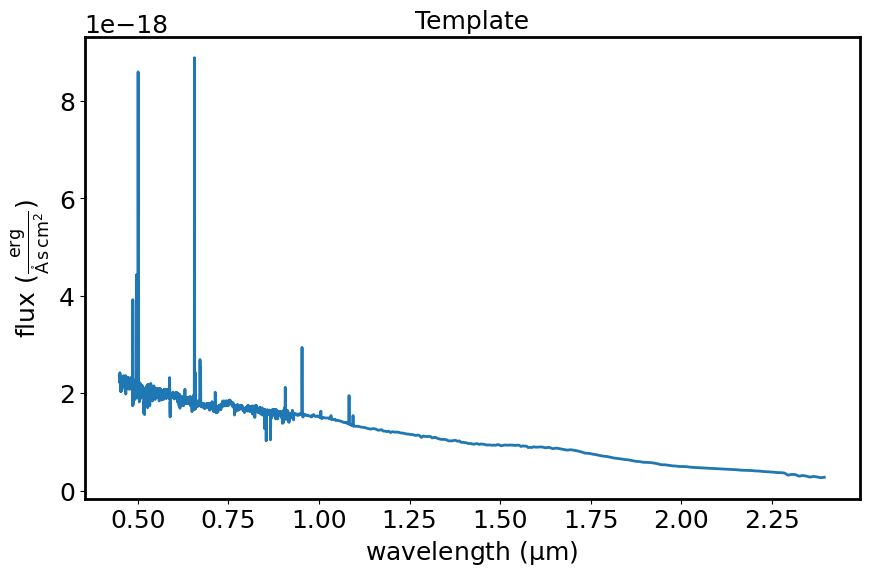

In [10]:
# Look at spectrum
plt.figure(figsize=[10, 6])
plt.plot(template_cut.spectral_axis, template_cut.flux)
plt.xlabel("wavelength ({:latex})".format(template_cut.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(template_cut.flux.unit))
plt.title("Template")
plt.show()

This diagram shows the template spectrum (flux vs wavelength) out to 2.4 micron to allow for some wavelength overlap with the observed spectrum.

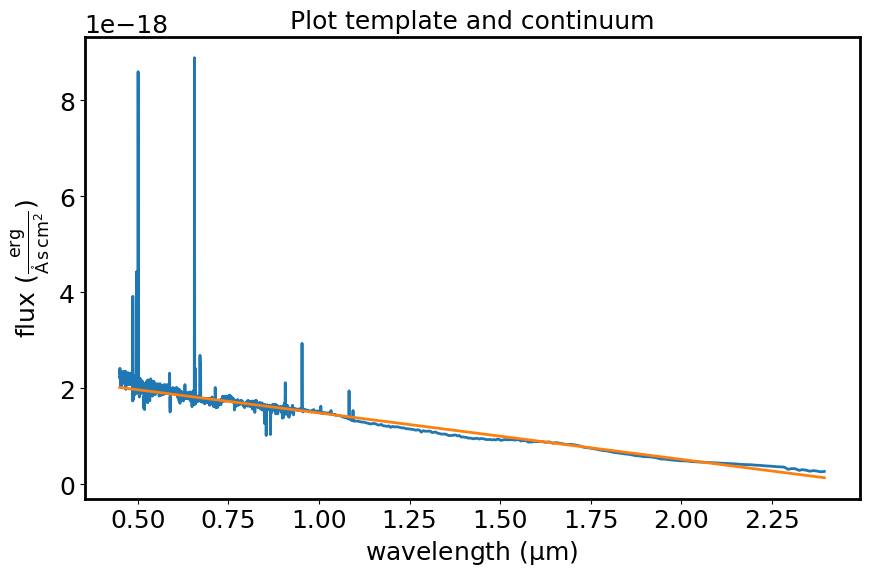

In [11]:
# Subtract continuum
mask_temp = ((template_cut.spectral_axis.value > 0.70) & (template_cut.spectral_axis.value < 2.40))

template_forcont = Spectrum1D(spectral_axis=template_cut.spectral_axis[mask_temp], flux=template_cut.flux[mask_temp])

# Use fit_generic_continuum
fit_temp = fit_generic_continuum(template_forcont, model=Linear1D())
cont_temp = fit_temp(template_cut.spectral_axis)
template_sub = template_cut - cont_temp


plt.figure(figsize=[10, 6])
plt.plot(template_cut.spectral_axis, template_cut.flux)
plt.plot(template_cut.spectral_axis, cont_temp)
plt.xlabel("wavelength ({:latex})".format(template_sub.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(template_sub.flux.unit))
plt.title("Plot template and continuum")
plt.show()

The diagram shows the template spectrum and the best-fitting continuum.

In [12]:
# Print Spectrum1D object
print(template_sub)

Spectrum1D (length=6069)
flux:             [ 2.0871e-19 erg / (Angstrom s cm2), ..., 1.3136e-19 erg / (Angstrom s cm2) ],  mean=5.0106e-20 erg / (Angstrom s cm2)
spectral axis:    [ 0.45008 um, ..., 2.395 um ],  mean=0.75618 um


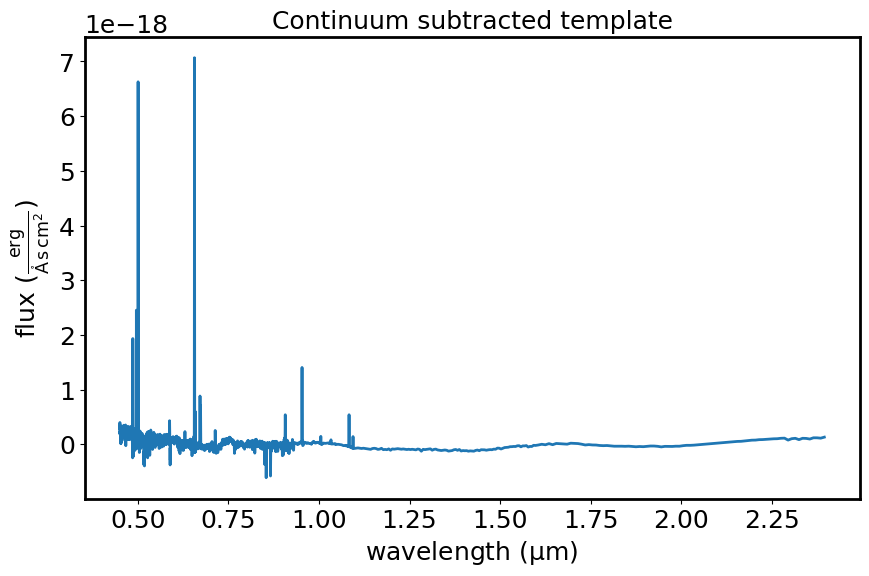

In [13]:
# Look at spectrum
plt.figure(figsize=[10, 6])
plt.plot(template_sub.spectral_axis, template_sub.flux)
plt.xlabel("wavelength ({:latex})".format(template_sub.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(template_sub.flux.unit))
plt.title("Continuum subtracted template")
plt.show()

This diagram shows the template spectrum (flux vs wavelength) after subtracting the fitted continuum.

<a id='continuum'></a>
### Subtract the continuum from the observed spectrum

We can use a different approach and do it with [SpectralRegion](https://specutils.readthedocs.io/en/stable/spectral_regions.html) here. We also need to include an uncertianty to the observed spectrum, if it is not included.

In [14]:
# Define Spectral Region
region = SpectralRegion(2.0*u.um, 3.0*u.um)
# Extract region
spec1d_cont = extract_region(fluxobs, region)
# Run fitting function
fit_obs = fit_generic_continuum(spec1d_cont, model=Linear1D(5))
# Apply to spectral axis
cont_obs = fit_obs(fluxobs.spectral_axis)

# Subtract continuum
spec1d_sub = fluxobs - cont_obs

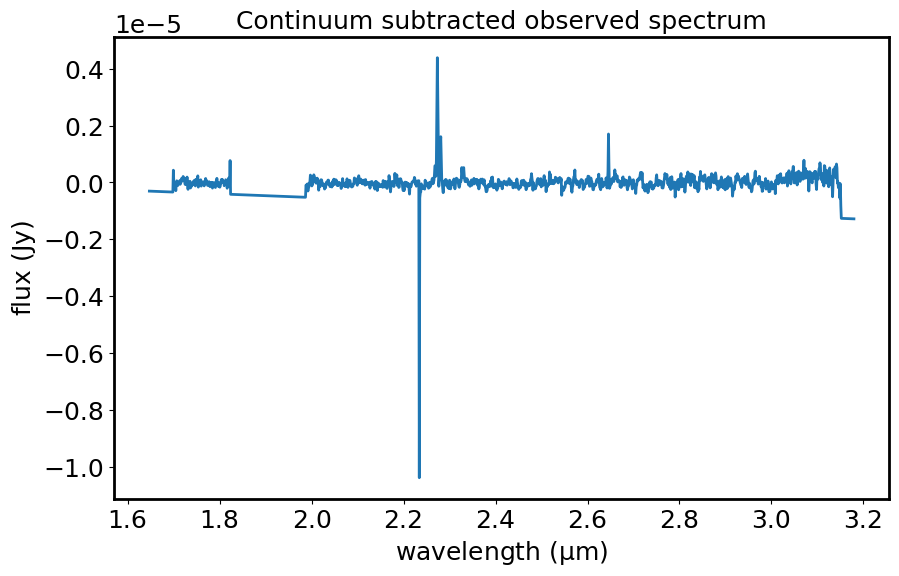

In [15]:
# Look at spectrum
plt.figure(figsize=[10, 6])
plt.plot(spec1d_sub.spectral_axis, spec1d_sub.flux)
plt.xlabel("wavelength ({:latex})".format(spec1d_sub.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spec1d_sub.flux.unit))
plt.title("Continuum subtracted observed spectrum")
plt.show()

This diagram shows the observed spectrum (flux vs wavelength) after subtracting the fitted continuum.

<a id='cleanup'></a>
### Clean up the spectrum
It is best to remove artifacts that can look like emission/absorption lines and remove big gaps. The selection of the clean part of the spectrum can be done using the GUI. If this is not performed manually, the following cell takes care of it programmatically.
<img src='./select_region.png' alt="Select a clean region of the spectrum" width="500"/>

In [16]:
viz2 = Specviz()
viz2.load_data(spec1d_sub, data_label='spectrum continuum subtracted')
viz2.show()

Application(config='specviz', docs_link='https://jdaviz.readthedocs.io/en/v3.7.0/specviz/index.html', events=[…

In [17]:
# Create a subset in the area of interest if it has not been created manually
try:
    region1 = viz2.get_spectra(data_label='spectrum continuum subtracted', subset_to_apply='Subset 1')
    print(region1)
    region1_exists = True
except Exception:
    print("There are no subsets selected.")
    region1_exists = False
    
# Spectral region for masking artifacts
if region1_exists is False:
    sv = viz2.app.get_viewer('spectrum-viewer')
    sv.toolbar_active_subset.selected = []
    sv.apply_roi(XRangeROI(2.24, 3.13))  

There are no subsets selected.


In [18]:
# Get spectrum out with mask
spec1d_region = viz2.get_spectral_regions()
spec1d_masked = extract_region(spec1d_sub, spec1d_region['Subset 1'], return_single_spectrum=True)

We visualize the observed and template continuum-subtracted spectra in a new instance of Specviz. Hit the Home button to see the entire wavelength range. The template spectrum will change unit to match the observed spectrum.

In [19]:
viz3 = Specviz()
viz3.load_data(spec1d_masked, data_label='observation')
viz3.load_data(template_sub, data_label='template')
viz3.show()

Application(config='specviz', docs_link='https://jdaviz.readthedocs.io/en/v3.7.0/specviz/index.html', events=[…

In [20]:
template_newunit = viz3.get_data('template', use_display_units=True)
template_newunit

<Spectrum1D(flux=<Quantity [1.41025005e-07, 1.27620683e-07, 1.88592894e-07, ...,
           2.23929907e-06, 2.13808264e-06, 2.51325990e-06] Jy>, spectral_axis=<SpectralAxis 
   (observer to target:
      radial_velocity=0.0 km / s
      redshift=0.0)
  [0.45008, 0.45017, 0.45026, ..., 2.375  , 2.385  , 2.395  ] um>)>

<a id='run_crosscorr'></a>
### Run the cross correlation function

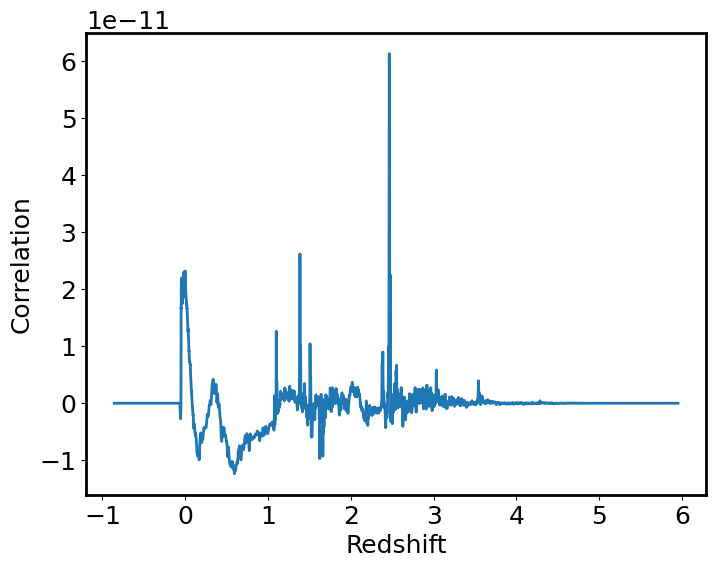

In [21]:
# Call the function
corr, lag = correlation.template_correlate(spec1d_masked, template_newunit, lag_units=u.one)

# Plot the correlation
plt.plot(lag, corr)
plt.xlabel("Redshift")
plt.ylabel("Correlation")
plt.show()

This diagram shows the correlation value vs the redshift. The spike (around redshift of 2.5) indicates the value where the observed and template spectra correlate best.

In [22]:
# Redshift based on maximum
index_peak = np.argmax(corr)
z = lag[index_peak]

print("Redshift from peak maximum: ", z)

Redshift from peak maximum:  2.4641266178613144


In [23]:
# Redshifted template_sub
template_sub_z = Spectrum1D(spectral_axis=template_sub.spectral_axis * (1. + z),
                            flux=template_sub.flux)

In [24]:
# Visualize the redshifted template and the observed spectrum
viz4 = Specviz()
viz4.load_data(spec1d_masked, data_label='Observed spectrum')
viz4.load_data(template_sub_z, data_label='Redshifted best template')
viz4.show()

Application(config='specviz', docs_link='https://jdaviz.readthedocs.io/en/v3.7.0/specviz/index.html', events=[…

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>